In [1]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ===============================
# 2. LOAD DATA
# ===============================

df = pd.read_csv("vietnam_housing_dataset.csv")

df.head()

,Address,Area,Frontage,Access Road,House direction,Balcony direction,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price
0,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",84.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Have certificate,NaN,8.60
1,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",60.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,7.50
2,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",90.0,6.0,13.0,Đông - Bắc,Đông - Bắc,5.0,NaN,NaN,Sale contract,NaN,8.90
3,"Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...",54.0,NaN,3.5,Tây - Nam,Tây - Nam,2.0,2.0,3.0,Have certificate,Full,5.35
4,"Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh",92.0,NaN,NaN,Đông - Nam,Đông - Nam,2.0,4.0,4.0,Have certificate,Full,6.90


In [3]:
# ===============================
# 3. BASIC CLEANING
# ===============================

# Drop duplicate
df = df.drop_duplicates()

# Nếu có cột ID thì drop
if "Id" in df.columns:
    df = df.drop(columns=["Id"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30229 entries, 0 to 30228
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            30229 non-null  object 
 1   Area               30229 non-null  float64
 2   Frontage           18665 non-null  float64
 3   Access Road        16932 non-null  float64
 4   House direction    8990 non-null   object 
 5   Balcony direction  5246 non-null   object 
 6   Floors             26626 non-null  float64
 7   Bedrooms           25067 non-null  float64
 8   Bathrooms          23155 non-null  float64
 9   Legal status       25723 non-null  object 
 10  Furniture state    16110 non-null  object 
 11  Price              30229 non-null  float64
dtypes: float64(7), object(5)
memory usage: 2.8+ MB


In [4]:
# ===============================
# 4. LOG TRANSFORM TARGET
# ===============================

df["Price"] = np.log1p(df["Price"])

In [5]:
# ===============================
# 5. SPLIT FEATURE TYPES
# ===============================

X = df.drop(columns=["Price"])
y = df["Price"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

Numeric columns: 6
Categorical columns: 5


In [6]:
# ===============================
# 6. TRAIN TEST SPLIT
# ===============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# ===============================
# 7. IMPUTATION
# ===============================

from sklearn.impute import SimpleImputer

# Numeric → median
num_imputer = SimpleImputer(strategy="median")

X_train_num = num_imputer.fit_transform(X_train[num_cols])
X_test_num = num_imputer.transform(X_test[num_cols])

# Categorical → most frequent
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train_cat = cat_imputer.fit_transform(X_train[cat_cols])
X_test_cat = cat_imputer.transform(X_test[cat_cols])

In [8]:
# ===============================
# 8. ONE HOT ENCODING
# ===============================

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False   # đổi từ sparse -> sparse_output
)

X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

In [9]:
# ===============================
# 9. CONCAT NUM + CAT
# ===============================

X_train_full = np.hstack([X_train_num, X_train_cat])
X_test_full = np.hstack([X_test_num, X_test_cat])

print("Final shape:", X_train_full.shape)

Final shape: (24183, 8910)


In [10]:
# ===============================
# 10. SCALING
# ===============================

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_full = scaler.fit_transform(X_train_full)
X_test_full = scaler.transform(X_test_full)

In [12]:
# ===============================
# 11. RIDGE REGRESSION (FAST)
# ===============================

alphas = np.logspace(-2, 2, 10)

ridge = RidgeCV(alphas=alphas, cv=3)
ridge.fit(X_train_full, y_train)

y_pred_ridge = ridge.predict(X_test_full)

print("Best alpha:", ridge.alpha_)
print("R2 Ridge:", r2_score(y_test, y_pred_ridge))

Best alpha: 100.0
R2 Ridge: 0.30388278823907655


In [15]:
# ===============================
# POLY ONLY NUMERIC FEATURES
# ===============================

from sklearn.preprocessing import PolynomialFeatures

# Poly chỉ trên numeric
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_num_poly = poly.fit_transform(X_train_num)
X_test_num_poly = poly.transform(X_test_num)

# Ghép lại với categorical đã encode
X_train_final = np.hstack([X_train_num_poly, X_train_cat])
X_test_final = np.hstack([X_test_num_poly, X_test_cat])

print("Final shape:", X_train_final.shape)

Final shape: (24183, 8931)


In [16]:
alphas = np.logspace(-2, 2, 10)

ridge_poly = RidgeCV(alphas=alphas, cv=3)
ridge_poly.fit(X_train_final, y_train)

y_pred_poly = ridge_poly.predict(X_test_final)

print("Best alpha:", ridge_poly.alpha_)
print("R2 Polynomial Ridge:", r2_score(y_test, y_pred_poly))

Best alpha: 0.5994842503189409
R2 Polynomial Ridge: 0.49675545374361896


In [17]:
# ===============================
# MODEL EVALUATION
# ===============================

from sklearn.metrics import mean_absolute_error

print("R2:", r2_score(y_test, y_pred_poly))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_poly)))
print("MAE:", mean_absolute_error(y_test, y_pred_poly))

R2: 0.49675545374361896
RMSE: 0.25548815253371465
MAE: 0.1844078199381739


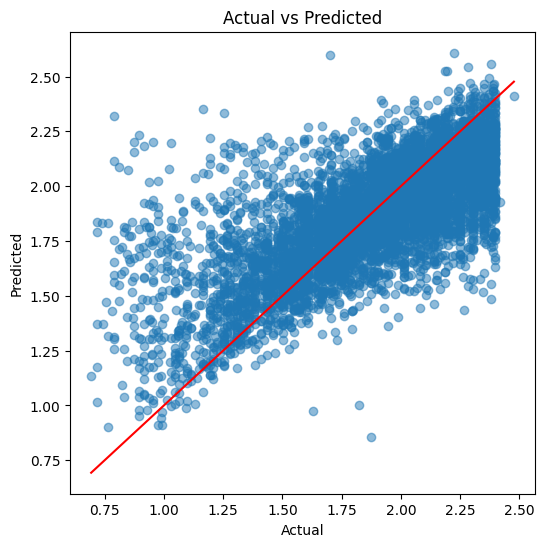

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_poly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

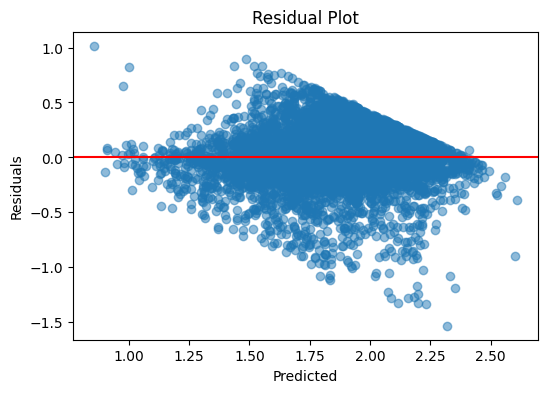

In [19]:
residuals = y_test - y_pred_poly

plt.figure(figsize=(6,4))
plt.scatter(y_pred_poly, residuals, alpha=0.5)
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

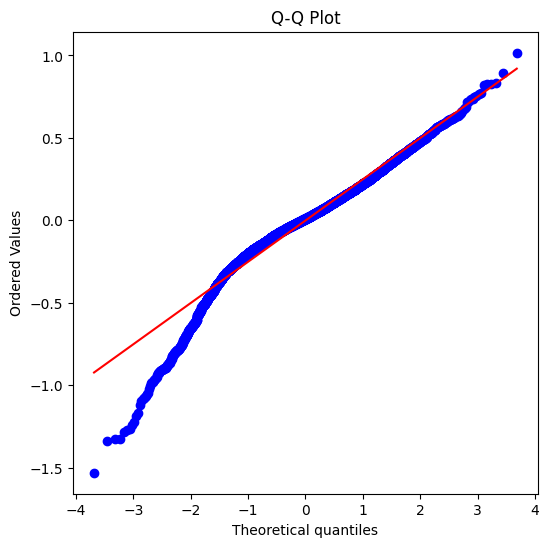

In [20]:
import scipy.stats as stats

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

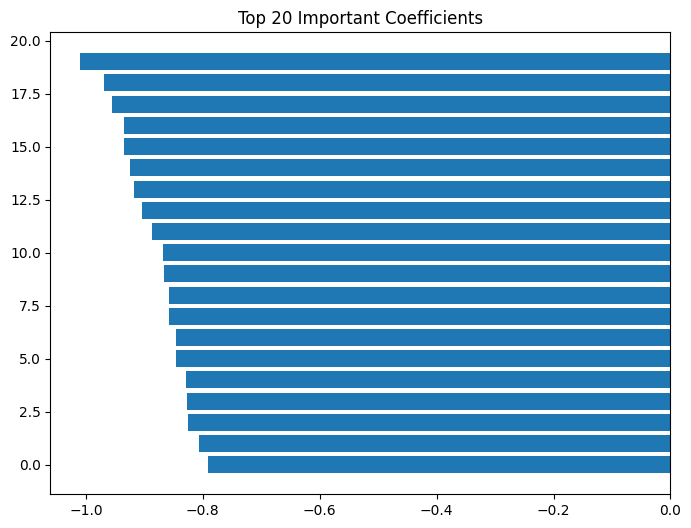

In [21]:
coef = ridge_poly.coef_

# Lấy top 20 absolute coefficient
top_idx = np.argsort(np.abs(coef))[-20:]

plt.figure(figsize=(8,6))
plt.barh(range(len(top_idx)), coef[top_idx])
plt.title("Top 20 Important Coefficients")
plt.show()

In [22]:
print("Ridge R2:", r2_score(y_test, y_pred_ridge))
print("Polynomial Ridge R2:", r2_score(y_test, y_pred_poly))

Ridge R2: 0.30388278823907655
Polynomial Ridge R2: 0.49675545374361896


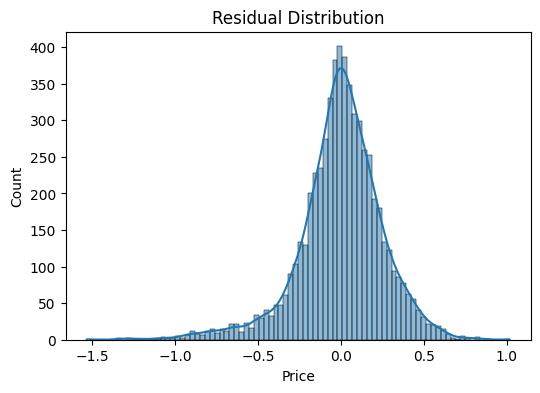

In [23]:
# ===============================
# RESIDUAL DISTRIBUTION
# ===============================

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

In [28]:
print("Train R2:", ridge.score(X_train_scaled, y_train))
print("Test R2:", ridge.score(X_test_scaled, y_test))

Train R2: 0.15068940017813692
Test R2: 0.14714138887651196
